In [3]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = r"\\SJCFS2\Adult Probation\Network\Research & Evaluation Unit\Research\Pretrial\FTA by Judge Agreement 2025\2020-2024 Data.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

In [4]:
# === Step 2: Clean Data ===

# Recommendations
def map_recommendation(rec):
    if rec == "Detain":
        return "Detain"
    else:
        return "Release"
    
df['Pretrial_Recommendation'] = df['Pretrial_Recommendation'].apply(map_recommendation)

# Gender
df['Gender'] = df['Gender'].str.strip().str.lower()
df['Gender'] = df['Gender'].map({
    'male': 'Male',
    'female': 'Female'
}).fillna('Other')

# Race
df['Race'] = df['Race'].str.strip().str.lower()

race_map = {
    'black': 'Black',
    'white': 'White',
    'hispanic': 'Hispanic',
    'hispanic/latin/mexican': 'Hispanic',
    'other asian': 'Asian/Pacific Islander',
    'asian': 'Asian/Pacific Islander',
    'chinese': 'Asian/Pacific Islander',
    'filipino': 'Asian/Pacific Islander',
    'cambodian': 'Asian/Pacific Islander',
    'pacific islander': 'Asian/Pacific Islander',
    'asian indian': 'Asian/Pacific Islander',
    'hawaiian': 'Asian/Pacific Islander',
    'vietnamese': 'Asian/Pacific Islander',
    'laotian': 'Asian/Pacific Islander',
    'korean': 'Asian/Pacific Islander',
    'japanese': 'Asian/Pacific Islander',
    'guamanian': 'Asian/Pacific Islander',
    'samoan': 'Asian/Pacific Islander'
}

df['Race'] = df['Race'].str.strip()
df['Race'] = df['Race'].map(race_map).fillna('Other')

# Create a new column to categorize VPRAI scores
df['VPRAI_Score_Grouped'] = df['VPRAI_Score'].apply(lambda x: str(x) if x < 5 else '5+')

In [5]:
#Review the data so far
df.head()

,AgeAtBooking,Gender,Race,VPRAI_Score,Booking_Date,Pretrial_Recommendation,Judge_Followed_Recommendation,Release_Type,FTA,VPRAI_Score_Grouped
0,52,Female,Hispanic,5,2021-08-19,Detain,No,OR with Pretrial Monitoring,No,5+
1,30,Male,Hispanic,2,2021-09-03,Release,Yes,OR with Pretrial Monitoring,No,2
2,55,Female,White,3,2021-08-15,Release,Yes,OR with Pretrial Monitoring,No,3
3,22,Female,Hispanic,3,2021-06-15,Release,Yes,Pretrial Monitoring with GPS,Yes,3
4,40,Female,White,2,2021-09-29,Release,Yes,OR with Pretrial Monitoring,No,2


In [6]:
# === Step 3: Define Groups ===
def define_group(row):
    if row['Pretrial_Recommendation'] == 'Detain' and row['Judge_Followed_Recommendation'] == 'No':
        return 'A'  # Judge released against recommendation
    elif row['Pretrial_Recommendation'] == 'Release' and row['Judge_Followed_Recommendation'] == 'Yes':
        return 'B'  # Judge released per recommendation
    else:
        return None

df['Group'] = df.apply(define_group, axis=1)

# Keep only Group A and B
df = df[df['Group'].isin(['A', 'B'])]

In [7]:
# === Step 4: Calculate FTA rates ===
fta_rates = df.groupby('Group')['FTA'].apply(lambda x: (x == 'Yes').sum() / x.count())
print("FTA Rate by Group:\n", fta_rates)

FTA Rate by Group:
 Group
A    0.185015
B    0.095275
Name: FTA, dtype: float64


In [8]:
# === Step 5: Chi-squared test ===
contingency = pd.crosstab(df['Group'], df['FTA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("\nChi-squared Test:")
print(f"Chi2 statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")


Chi-squared Test:
Chi2 statistic: 91.1206
P-value: 0.0000


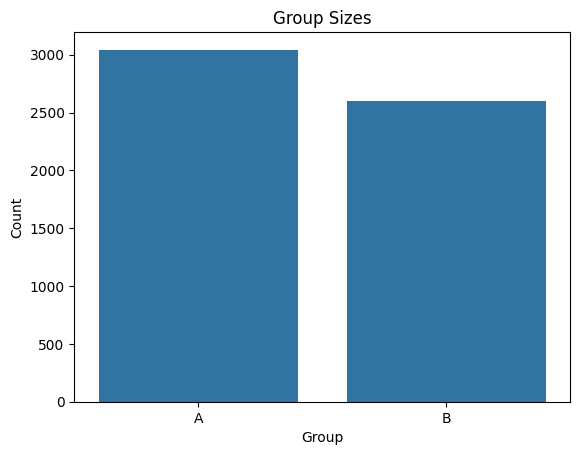

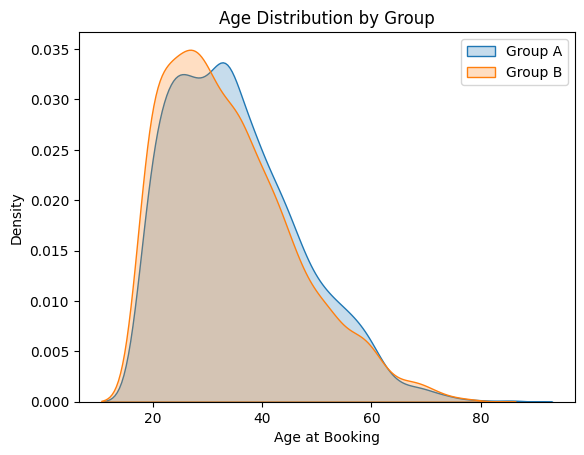

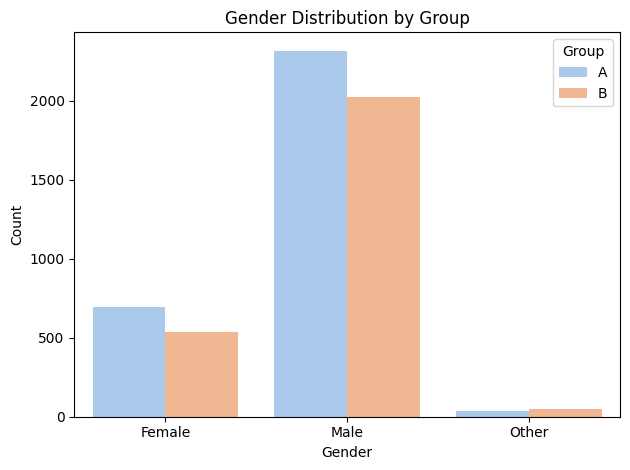

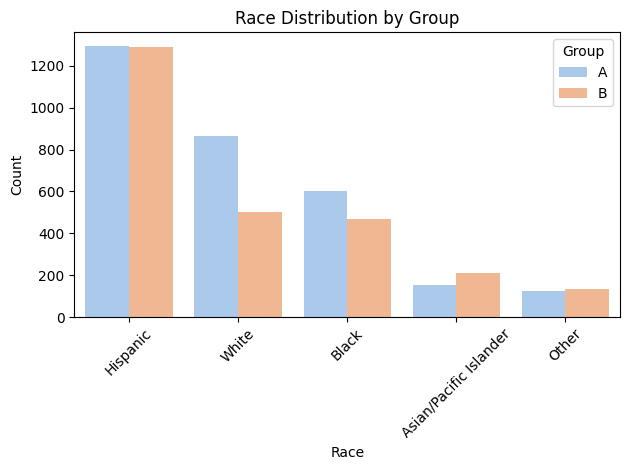

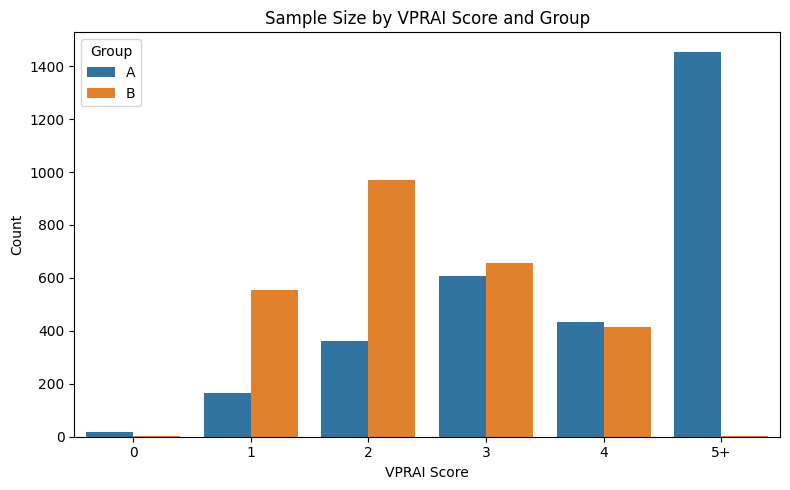

In [9]:
# === Compare Group A vs B Distributions ===

# Group Sizes
sns.countplot(data=df, x='Group')
plt.title('Group Sizes')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

# Age Distribution by Group
sns.kdeplot(data=df[df['Group'] == 'A'], x='AgeAtBooking', label='Group A', fill=True)
sns.kdeplot(data=df[df['Group'] == 'B'], x='AgeAtBooking', label='Group B', fill=True)
plt.title('Age Distribution by Group')
plt.xlabel('Age at Booking')
plt.legend()
plt.show()

# Gender Distribution by Group
sns.countplot(data=df, x='Gender', hue='Group', palette='pastel')
plt.title('Gender Distribution by Group')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# Race Distribution by Group
sns.countplot(data=df, x='Race', hue='Group', palette='pastel')
plt.title('Race Distribution by Group')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sample Size by VPRAI Score and Group
vprai_counts = df.groupby(['VPRAI_Score_Grouped', 'Group']).size().reset_index(name='Count')
plt.figure(figsize=(8, 5))
sns.barplot(data=vprai_counts, x='VPRAI_Score_Grouped', y='Count', hue='Group')
plt.title('Sample Size by VPRAI Score and Group')
plt.xlabel('VPRAI Score')
plt.ylabel('Count')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

C:\Users\jfox\AppData\Local\Temp\ipykernel_11512\1806038708.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Group", y="FTA_Rate", data=fta_df, palette="Blues_d")


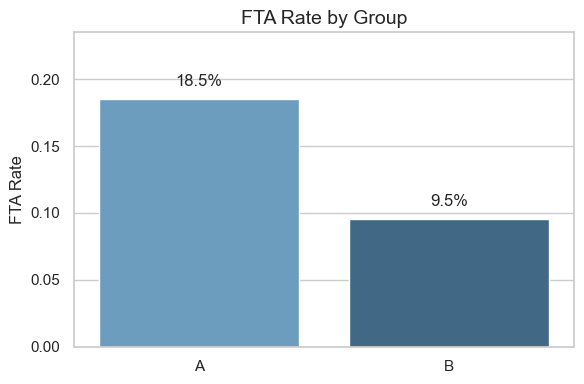

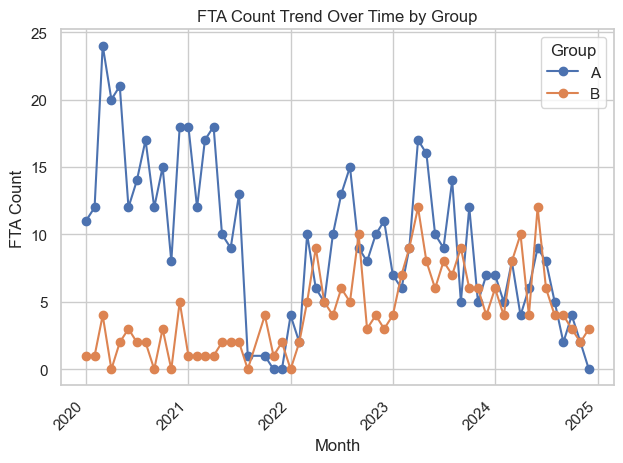

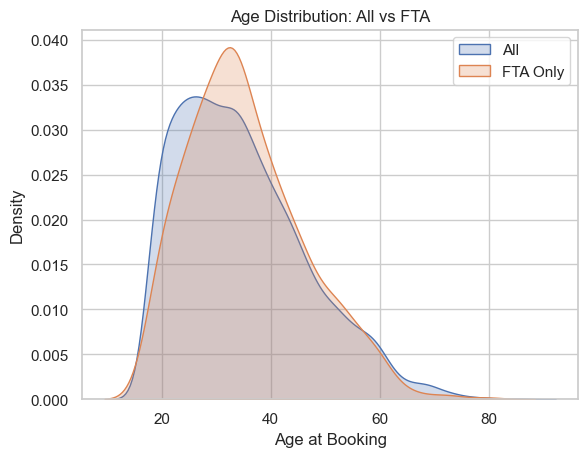

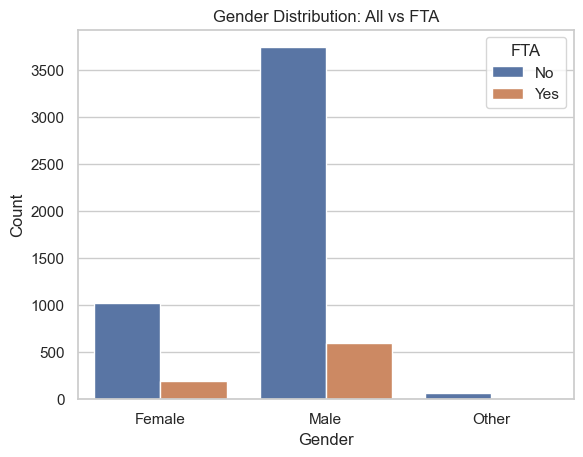

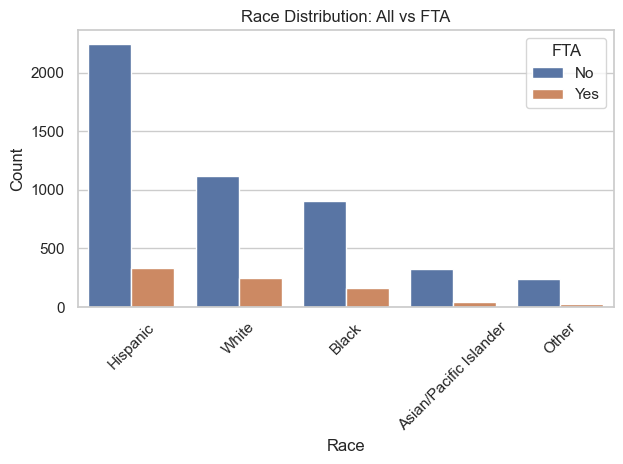

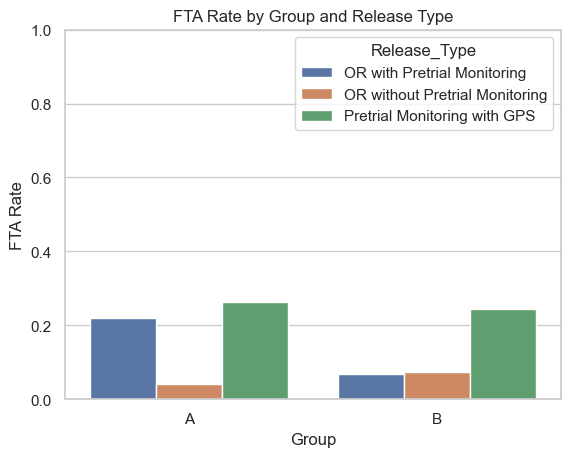

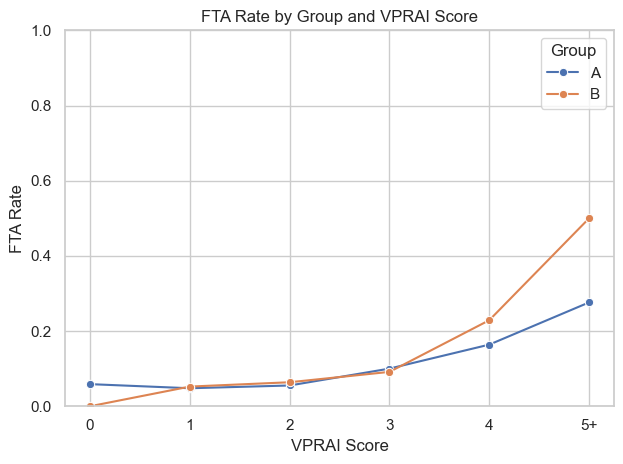

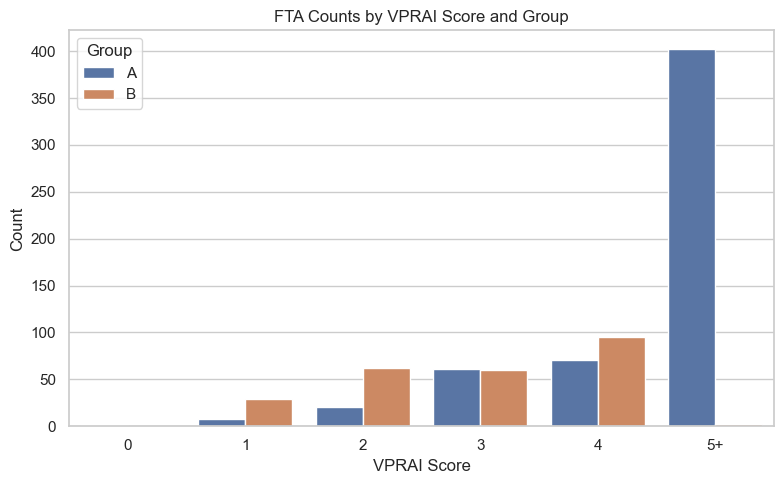

In [10]:
# === Analyze FTA Rates and Patterns ===

# Convert fta_rates to DataFrame for Plotting
fta_df = fta_rates.reset_index()
fta_df.columns = ['Group', 'FTA_Rate']

# Plot FTA rate by group
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x="Group", y="FTA_Rate", data=fta_df, palette="Blues_d")
for index, row in fta_df.iterrows():
    plt.text(index, row['FTA_Rate'] + 0.01, f"{row['FTA_Rate']*100:.1f}%", ha='center', fontsize=12)
plt.title("FTA Rate by Group", fontsize=14)
plt.ylabel("FTA Rate")
plt.ylim(0, max(fta_df['FTA_Rate']) + 0.05)
plt.xlabel("")
plt.tight_layout()
plt.show()

# FTA Count Trend Over Time by Group
df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
fta_trend = df[df['FTA'] == 'Yes'].groupby([df['Booking_Date'].dt.to_period('M'), 'Group']).size().unstack(fill_value=0)
fta_trend.index = fta_trend.index.to_timestamp()
fta_trend.plot(marker='o')
plt.title('FTA Count Trend Over Time by Group')
plt.xlabel('Month')
plt.ylabel('FTA Count')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Age Distribution (All vs FTA)
sns.kdeplot(data=df, x='AgeAtBooking', label='All', fill=True)
sns.kdeplot(data=df[df['FTA'] == 'Yes'], x='AgeAtBooking', label='FTA Only', fill=True)
plt.title('Age Distribution: All vs FTA')
plt.xlabel('Age at Booking')
plt.legend()
plt.show()

# Gender Distribution (All vs FTA)
fta_flag = df.copy()
fta_flag['FTA_Flag'] = fta_flag['FTA'] == 'Yes'
sns.countplot(data=fta_flag, x='Gender', hue='FTA_Flag')
plt.title('Gender Distribution: All vs FTA')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='FTA', labels=['No', 'Yes'])
plt.show()

# Race Distribution (All vs FTA)
sns.countplot(data=fta_flag, x='Race', hue='FTA_Flag')
plt.title('Race Distribution: All vs FTA')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='FTA', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# FTA Rate by Group and Release Type
fta_by_release = df.groupby(['Group', 'Release_Type'])['FTA'].apply(lambda x: (x == 'Yes').sum() / x.count()).reset_index()
fta_by_release.columns = ['Group', 'Release_Type', 'FTA_Rate']
sns.barplot(data=fta_by_release, x='Group', y='FTA_Rate', hue='Release_Type')
plt.title('FTA Rate by Group and Release Type')
plt.ylabel('FTA Rate')
plt.ylim(0, 1)
plt.show()

# FTA Rate by Group and VPRAI Score
fta_by_vprai = df.groupby(['Group', 'VPRAI_Score_Grouped'])['FTA'].apply(lambda x: (x == 'Yes').sum() / x.count()).reset_index()
fta_by_vprai.columns = ['Group', 'VPRAI_Score', 'FTA_Rate']
fta_by_vprai['VPRAI_Score'] = pd.Categorical(fta_by_vprai['VPRAI_Score'], 
                                             categories=[str(i) for i in range(0,5)] + ['5+'], 
                                             ordered=True)
fta_by_vprai = fta_by_vprai.sort_values('VPRAI_Score')
sns.lineplot(data=fta_by_vprai, x='VPRAI_Score', y='FTA_Rate', hue='Group', marker='o')
plt.title('FTA Rate by Group and VPRAI Score')
plt.ylabel('FTA Rate')
plt.ylim(0, 1)
plt.xlabel('VPRAI Score')
plt.tight_layout()
plt.show()

# FTA Counts by VPRAI Score and Group
vprai_FTA_counts = df[df['FTA'] == 'Yes'].groupby(['VPRAI_Score_Grouped', 'Group']).size().reset_index(name='Count')
plt.figure(figsize=(8, 5))
sns.barplot(data=vprai_FTA_counts, x='VPRAI_Score_Grouped', y='Count', hue='Group')
plt.title('FTA Counts by VPRAI Score and Group')
plt.xlabel('VPRAI Score')
plt.ylabel('Count')
plt.legend(title='Group')
plt.tight_layout()
plt.show()
